In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Visualizationdf_e.shape
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score



In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the dataset
#df_n = pd.read_csv('../data/processed/cleaned_data_Namrata_NAN.csv')
df_e = pd.read_csv('../data/raw/houses_Madrid.csv')



In [4]:
df_e.columns

Index(['Unnamed: 0', 'id', 'title', 'subtitle', 'sq_mt_built', 'sq_mt_useful',
       'n_rooms', 'n_bathrooms', 'n_floors', 'sq_mt_allotment', 'latitude',
       'longitude', 'raw_address', 'is_exact_address_hidden', 'street_name',
       'street_number', 'portal', 'floor', 'is_floor_under', 'door',
       'neighborhood_id', 'operation', 'rent_price', 'rent_price_by_area',
       'is_rent_price_known', 'buy_price', 'buy_price_by_area',
       'is_buy_price_known', 'house_type_id', 'is_renewal_needed',
       'is_new_development', 'built_year', 'has_central_heating',
       'has_individual_heating', 'are_pets_allowed', 'has_ac',
       'has_fitted_wardrobes', 'has_lift', 'is_exterior', 'has_garden',
       'has_pool', 'has_terrace', 'has_balcony', 'has_storage_room',
       'is_furnished', 'is_kitchen_equipped', 'is_accessible',
       'has_green_zones', 'energy_certificate', 'has_parking',
       'has_private_parking', 'has_public_parking',
       'is_parking_included_in_price', 'parki

In [5]:
df_ = df_e[['sq_mt_built','n_rooms', 'n_bathrooms', 'floor', 'buy_price', 'is_renewal_needed',
       'built_year', 'has_lift', 'is_exterior', 'neighborhood_id']]

In [6]:
 # get neightbourhood and district column
chop = df_['neighborhood_id'].str.extract(r'Neighborhood (\d+): (.*?) \(.*\) - District (\d+): (.*)')
df_['neighbourhood']= chop[1]+ ' ' +chop[0]
df_['district']= chop[3] + ' ' + chop[2]

In [7]:
df_.drop(columns=['neighborhood_id','neighbourhood'],inplace=True)

In [8]:
df_.head(2)

,sq_mt_built,n_rooms,n_bathrooms,floor,buy_price,is_renewal_needed,built_year,has_lift,is_exterior,district
0,64.0,2,1.0,3,85000,False,1960.0,False,True,Villaverde 21
1,70.0,3,1.0,4,129900,True,NaN,True,True,Villaverde 21


In [9]:
# Correlation heatmap
numeric_cols = df_.select_dtypes(include=[np.number]).columns#

df_[numeric_cols].corr()['buy_price'].sort_values(ascending=False)

buy_price      1.000000
sq_mt_built    0.832039
n_bathrooms    0.772218
n_rooms        0.608893
built_year     0.008514
Name: buy_price, dtype: float64

#### Data Cleaning

In [10]:
df_.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
21737    False
21738    False
21739    False
21740    False
21741    False
Length: 21742, dtype: bool

In [11]:
df_without_duplicates = df_.drop_duplicates()

In [12]:
df_without_duplicates.isna().sum()

sq_mt_built            115
n_rooms                  0
n_bathrooms             16
floor                 2477
buy_price                0
is_renewal_needed        0
built_year           11084
has_lift              2249
is_exterior           2888
district                 0
dtype: int64

In [13]:
mean_year = df_without_duplicates['built_year'].mean()
round(mean_year)
df_without_duplicates['built_year'].fillna(round(mean_year), inplace=True)

In [14]:
df_without_duplicates.isna().sum()

sq_mt_built           115
n_rooms                 0
n_bathrooms            16
floor                2477
buy_price               0
is_renewal_needed       0
built_year              0
has_lift             2249
is_exterior          2888
district                0
dtype: int64

In [15]:
df_without_duplicates_without_na = df_without_duplicates.dropna()

In [16]:
df_without_duplicates_without_na.isna().sum()

sq_mt_built          0
n_rooms              0
n_bathrooms          0
floor                0
buy_price            0
is_renewal_needed    0
built_year           0
has_lift             0
is_exterior          0
district             0
dtype: int64

In [17]:
df = df_without_duplicates_without_na

<Axes: xlabel='buy_price', ylabel='Count'>

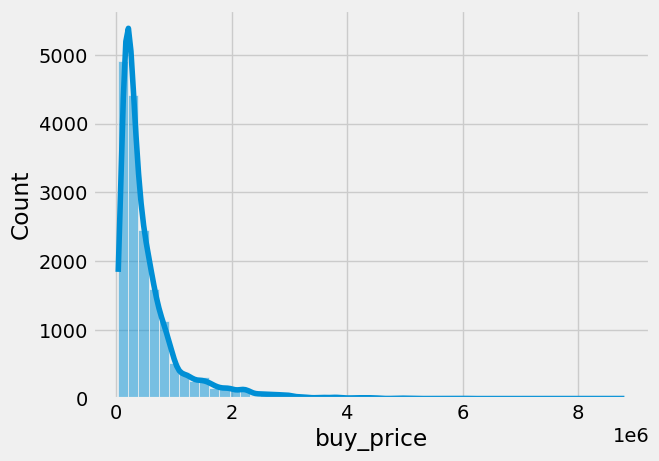

In [18]:
sns.histplot(df['buy_price'],kde = True,bins=50)

In [19]:
# This distribution is skewed - this can be improved to make it more normally distributed

<Axes: xlabel='buy_price', ylabel='Count'>

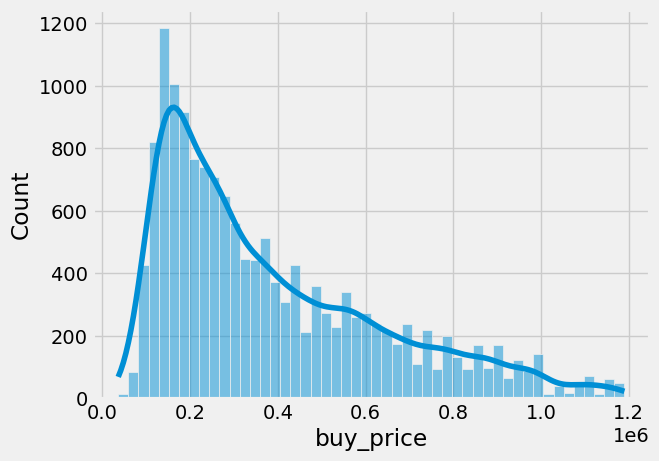

In [20]:
q = df['buy_price'].quantile(0.90)

df = df[df['buy_price']<q]

sns.histplot(df['buy_price'],kde = True,bins=50)

In [21]:
df['built_year'].value_counts()

built_year
1971.0    8239
1960.0     379
1970.0     365
1965.0     330
1900.0     287
          ... 
1889.0       1
1881.0       1
1908.0       1
1891.0       1
1938.0       1
Name: count, Length: 148, dtype: int64

<Axes: xlabel='built_year', ylabel='Count'>

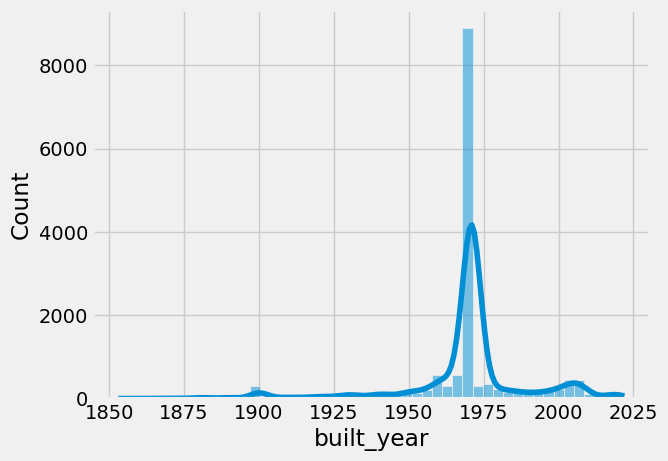

In [22]:

df = df[(df['built_year']>1850) & (df['built_year']< 2024)]
sns.histplot(df['built_year'],kde = True,bins=50)

In [23]:
df.shape

(15229, 10)

In [24]:
df['floor'].value_counts().index

Index(['1', '2', '3', 'Bajo', '4', '5', '6', '7', '8', 'Entreplanta exterior',
       '9', 'Semi-sótano exterior', 'Semi-sótano interior',
       'Entreplanta interior', 'Sótano interior', 'Sótano exterior'],
      dtype='object', name='floor')

In [25]:
# Dictionary mapping numbers to words
number_to_word = {
    '1': 'one', '2': 'two', '3': 'three', '4': 'four', '5': 'five',
    '6': 'six', '7': 'seven', '8': 'eight', '9': 'nine', 'Bajo': 'zero',
    'Semi-sótano exterior':'semi-basement','Semi-sótano interior':'semi-basement',
    'Entreplanta interior':'mezzanine', 'Sótano interior':'basement',
    'Sótano exterior':'basement','Entreplanta exterior':'mezzanine'
}

# Replace numbers with words directly using the dictionary
df['floor'] = df['floor'].replace(number_to_word)

In [26]:
df['floor'].value_counts()

floor
one              3557
two              2790
three            2365
zero             1846
four             1789
five             1004
six               692
seven             432
eight             263
mezzanine         241
nine              137
semi-basement      87
basement           26
Name: count, dtype: int64

In [27]:
#conda install -c conda-forge pycaret

In [28]:
from pycaret.regression import *

In [29]:
# Setup the environment in PyCaret
regression_setup = setup(
    data=df,
    #test_data=test_data,
    target = 'buy_price',
    session_id=9,
    ignore_features=[],
    categorical_features=['district','floor'],
    numeric_imputation = 'mean',
    categorical_imputation = 'mode',
    remove_multicollinearity=True,
    transformation= True,
    transformation_method = 'yeo-johnson',
    normalize = True,
    normalize_method = 'zscore'
    )

,Description,Value
0,Session id,9
1,Target,buy_price
2,Target type,Regression
3,Original data shape,"(15229, 10)"
4,Transformed data shape,"(15229, 41)"
5,Transformed train set shape,"(10660, 41)"
6,Transformed test set shape,"(4569, 41)"
7,Numeric features,4
8,Categorical features,2
9,Preprocess,True


In [30]:
# compare baseline models
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,60655.8237,8124950794.5170,90070.0121,0.8740,0.2166,0.1712,0.3040
rf,Random Forest Regressor,60027.3727,8318742418.2544,91118.8220,0.8710,0.2222,0.1738,0.4300
et,Extra Trees Regressor,61022.8779,8937190525.7530,94385.3337,0.8615,0.2300,0.1765,0.4280
gbr,Gradient Boosting Regressor,66843.3221,9378965143.0466,96762.6392,0.8546,0.2422,0.1985,0.1710
lar,Least Angle Regression,84979.5372,12791958698.8325,113058.4645,0.8017,0.5361,0.2954,0.0530
llar,Lasso Least Angle Regression,84979.2363,12791953498.2970,113058.4419,0.8017,0.5366,0.2954,0.0540
br,Bayesian Ridge,84958.1062,12791935040.1247,113058.2447,0.8017,0.5349,0.2951,0.0550
ridge,Ridge Regression,84977.9581,12791945835.1874,113058.3992,0.8017,0.5381,0.2954,0.0560
lasso,Lasso Regression,84979.2011,12791951733.5595,113058.4340,0.8017,0.5367,0.2954,0.1650
lr,Linear Regression,84980.3002,12791912182.5638,113058.2631,0.8017,0.5400,0.2954,0.3050


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [31]:
# predict on test set
holdout_pred = predict_model(best_model)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,60721.5848,8146206944.1284,90256.3402,0.8737,0.2168,0.1713


In [33]:
# show predictions df
holdout_pred[['buy_price','prediction_label']].head()

,buy_price,prediction_label
15559,218400,171852.954637
4258,570000,720307.719654
14012,980000,947486.851489
18199,295000,444679.390124
10580,228000,184869.144432


In [46]:
df.to_csv('../data/processed/Madrid_Dataset_wo_null_ayushya.csv')